In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
# download the dataset
if not os.path.exists("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
else:
    print("Dataset Already Exists")

Dataset Already Exists


In [ ]:
# Import with pandas
import pandas as pd
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info(), len(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


(None, 2787)

In [ ]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


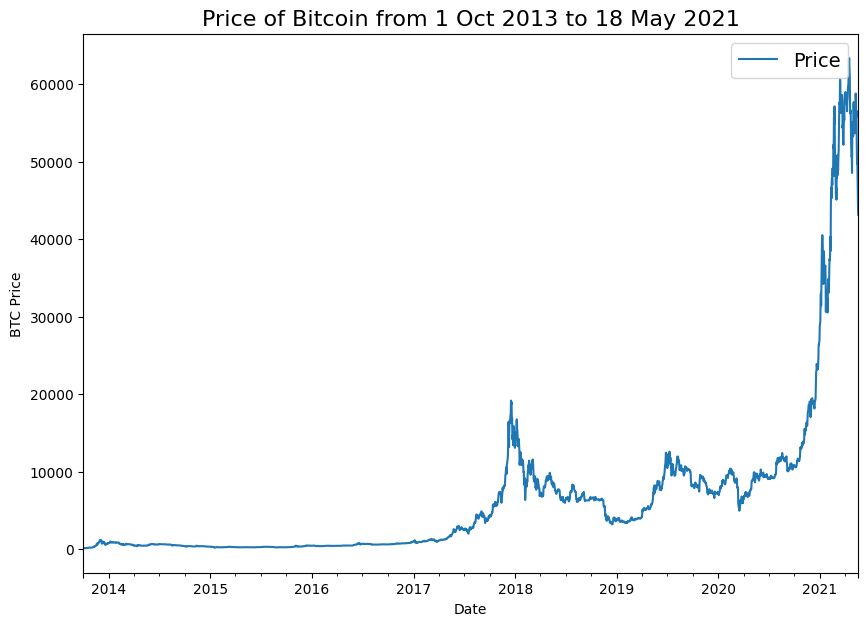

In [ ]:
import matplotlib.pyplot as plt
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

(2229,) (558,) (2229,) (558,)


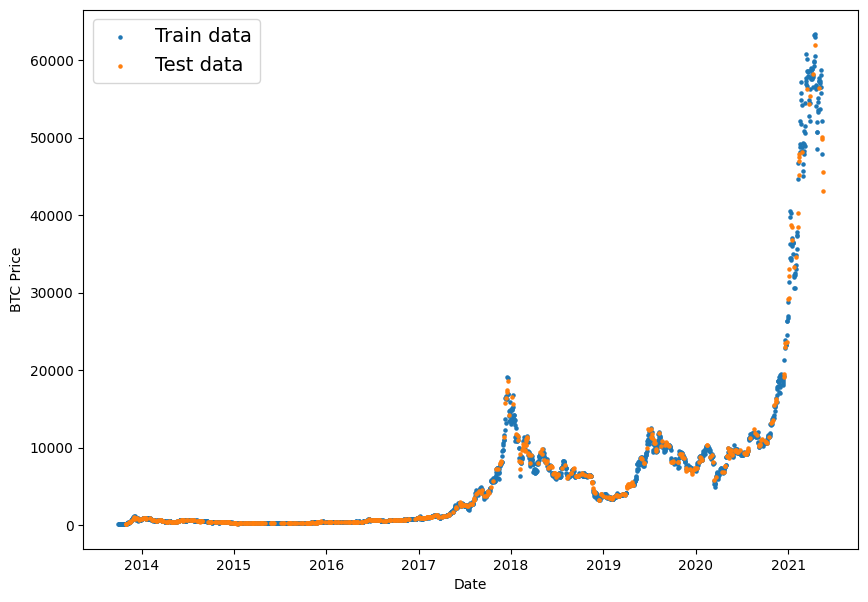

In [ ]:
# creating train/test split - the wrong way
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

(2229, 558, 2229, 558)

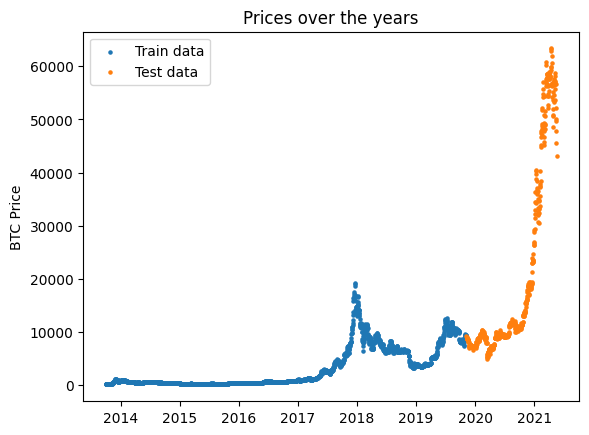

In [ ]:
# Creating train/test split - the right way
split_size = int(0.8 * len(prices)) # 80% train, 20% test
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.ylabel("BTC Price")
plt.title("Prices over the years")
plt.legend()

len(X_train), len(X_test), len(y_train), len(y_test)

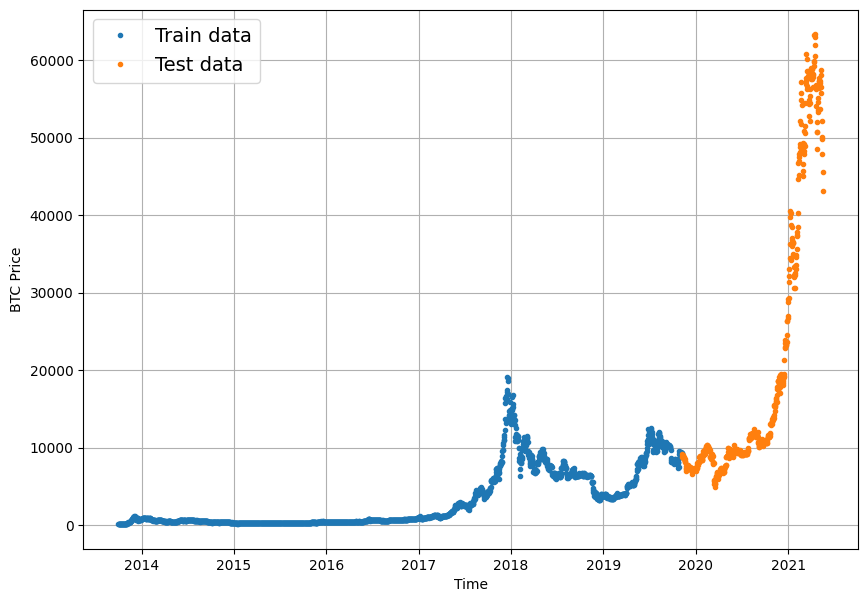

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
        plt.grid(True)

plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')

# Modelling experiments

* **horizon** - the number of timesteps to be predicted
* **window** - number of observations used to predict the horizon

0. Naive model - baseline
1. Dense model (horizon = 1, window = 7)
2. Same as model 1 (horizon = 1, window = 30)
3. Same as model 1 (horizon = 7, window = 30)
4. Conv1D
5. LSTM
6. Same as model 1 (multivariate model)
7. N-BEATS algorithm
8. Ensemble
9. Future prediction model
10. Same as model 1 (turkey data introduced)

In [ ]:
# Model 0 -Naive mode;
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

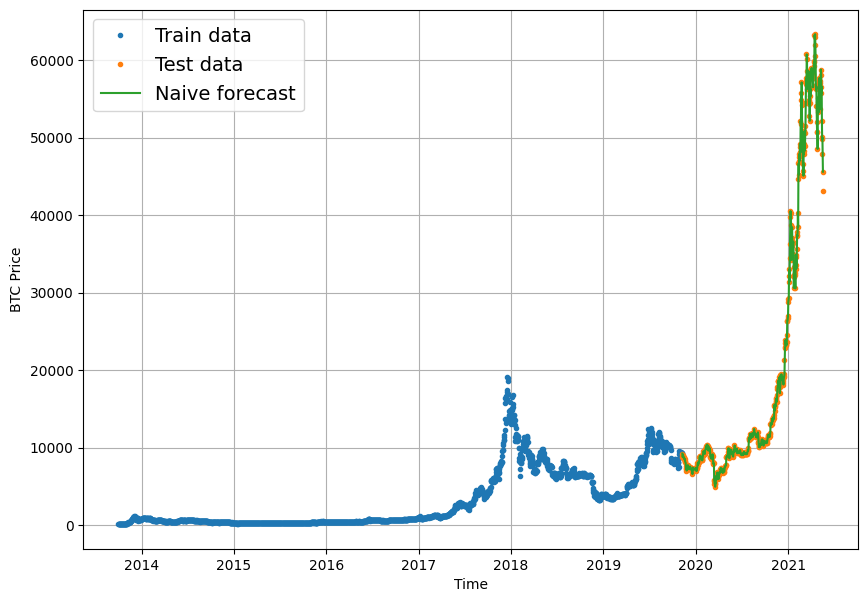

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

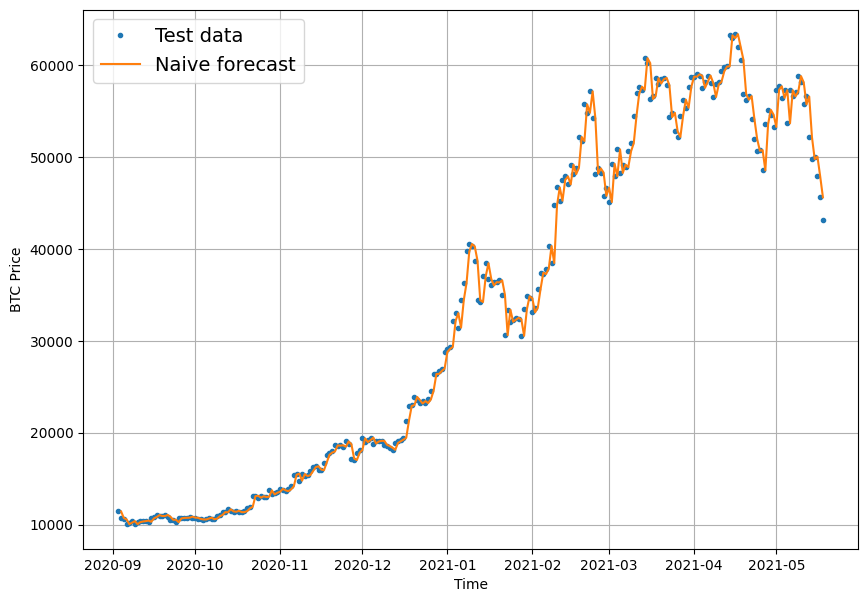

In [ ]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast")

#### Evaluating time series forecasting

In [ ]:
# implement MASE error - mean absolute scaled error
def mean_absolute_scaled_error(y_true, y_pred):
    '''
    No seasonality is assumed
    '''
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [ ]:
# Create loss function to return all loss metrics in dictionary format
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

model_0_results = evaluate_preds(y_test[1:], naive_forecast)
model_0_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Format data - windowing our dataset

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

def get_labelled_windows(x, horizon=HORIZON):
    return x[:,:-horizon], x[:, -horizon:]

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


#### Use tensorflow to make it easier
**tf.keras.prrprocessing.timeseries.dataset_from_array(X)**

In [ ]:
# train = tf.keras.preprocessing.timeseries_dataset_from_array(prices, targets=None, sequence_length=7)
# label = tf.keras.preprocessing.timeseries_dataset_from_array(prices, targets=None, sequence_length=1, start_index=7)
# next(iter(train))[:5], next(iter(label))[:5]

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

# full_windows, full_labels = make_windows(prices)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(full_windows)

(2224, 556, 2780)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
], name="model_1_dense")

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

history1 = model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels))

Epoch 1/100
18/18 [==============================] - 3s 28ms/step - loss: 4135.2271 - mae: 4135.2271 - val_loss: 13174.4160 - val_mae: 13174.4160
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 808.5651 - mae: 808.5651 - val_loss: 3302.2476 - val_mae: 3302.2476
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 316.8170 - mae: 316.8170 - val_loss: 1318.6960 - val_mae: 1318.6960
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 217.2568 - mae: 217.2568 - val_loss: 1214.9950 - val_mae: 1214.9950
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 198.8495 - mae: 198.8495 - val_loss: 1102.1606 - val_mae: 1102.1606
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 199.0860 - mae: 199.0860 - val_loss: 1077.4313 - val_mae: 1077.4313
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 192.6812 - mae: 192.6812 - val_loss: 1027.1470 - val_mae: 1027.1470
Epoch 8

In [ ]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 653.5304 - mae: 653.5304


[653.5303955078125, 653.5303955078125]

In [ ]:
# make forecast with the model (on the test dataset)
def make_preds(model, data):
    return tf.squeeze(model.predict(data))

# use it on model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8716.782, 8636.152, 8898.066, 8654.249, 8591.533, 8611.646,
       8539.608, 8396.215, 8324.384, 8396.689], dtype=float32)>

In [ ]:
model_1_results = evaluate_preds(tf.squeeze(test_labels),
                                   model_1_preds)
model_1_results, model_0_results

({'mae': 653.5304,
  'mse': 1348881.5,
  'rmse': 1161.4136,
  'mape': 2.9743311,
  'mase': 1.1480719},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

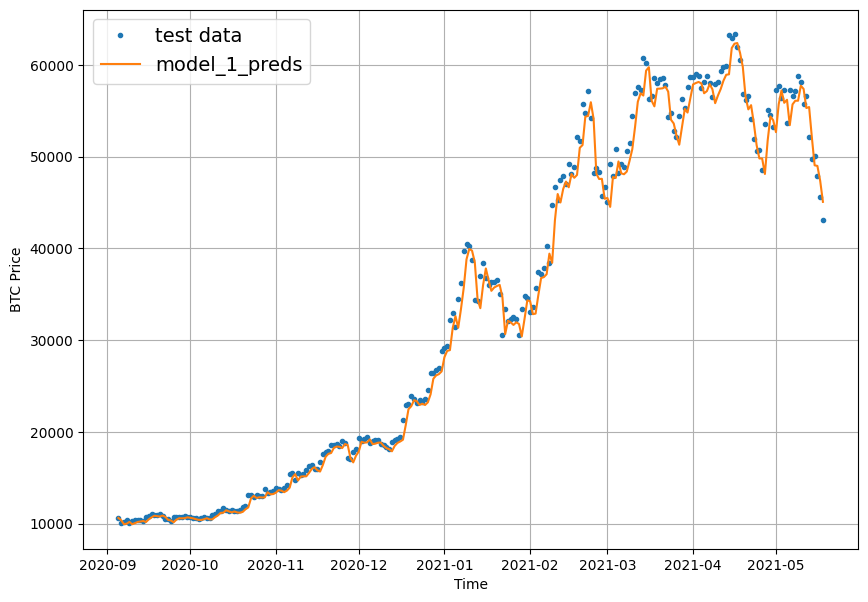

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(X_test[-len(test_windows):],
                 test_labels[:, 0],
                 start=300,
                 label='test data')
plot_time_series(X_test[-len(test_windows):],
                 model_1_preds,
                 start=300,
                 format='-',
                 label='model_1_preds')


In [ ]:
# Model 2 - model_1 with window_size=30 and horizon=1
full_windows_30_1, full_labels_30_1 = make_windows(prices, window_size=30, horizon=1)
train_windows_30_1, test_windows_30_1, train_labels_30_1, test_labels_30_1 = make_train_test_splits(full_windows_30_1, full_labels_30_1)

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(HORIZON)
], name='model_2_dense_30_1')
model_2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())
history_2 = model_2.fit(train_windows_30_1, train_labels_30_1,
                        epochs=100,
                        batch_size=128,
                        validation_data=(test_windows_30_1, test_labels_30_1))

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 1057.5996 - val_loss: 3526.6455
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 371.7641 - val_loss: 1772.2939
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 298.8268 - val_loss: 1609.9398
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 264.6052 - val_loss: 1420.1936
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 246.9180 - val_loss: 1336.0050
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 244.8627 - val_loss: 1418.2858
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 216.1116 - val_loss: 1148.1342
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 203.7134 - val_loss: 1113.1897
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 193.9721 - val_loss: 1172.0900
Epoch 10/100
18/18 [==============================] - 0s 4ms/s

In [ ]:
model_2.evaluate(test_windows_30_1, test_labels_30_1)

18/18 [==============================] - 0s 2ms/step - loss: 651.8065


651.8064575195312

In [ ]:
model_2_preds = make_preds(model_2, test_windows_30_1)
model_2_results = evaluate_preds(tf.squeeze(test_labels_30_1), model_2_preds)
model_2_results

18/18 [==============================] - 0s 3ms/step


{'mae': 651.8064,
 'mse': 1417453.2,
 'rmse': 1190.5685,
 'mape': 3.0340319,
 'mase': 1.139364}

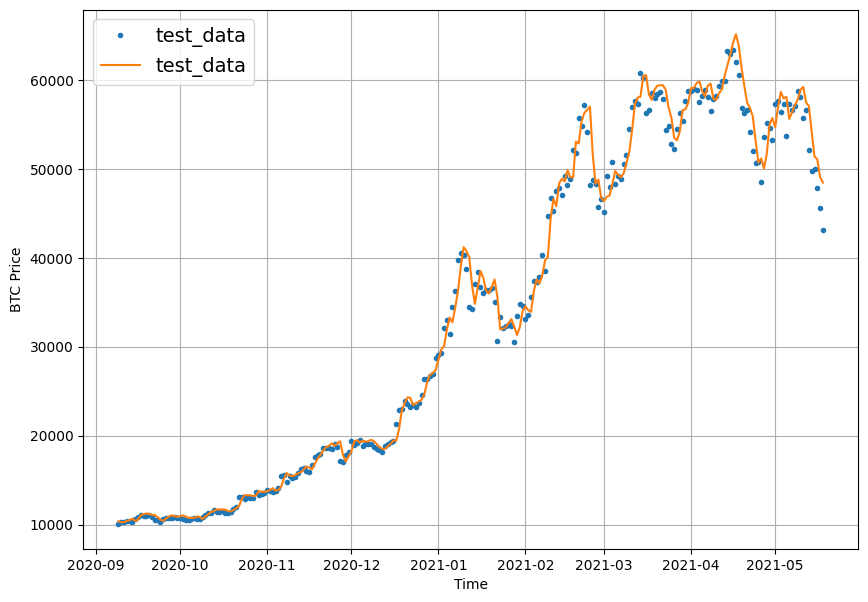

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows_30_1):], test_labels_30_1[:, 0], start=offset, label='test_data')
plot_time_series(X_test[-len(test_windows_30_1):], model_2_preds, start=offset, format='-', label='test_data')

In [ ]:
# Model 3 - model_1(window=30, horizon=7)
full_windows_30_7, full_labels_30_7 = make_windows(prices, window_size=30, horizon=7)
train_windows_30_7, test_windows_30_7, train_labels_30_7, test_labels_30_7 = make_train_test_splits(full_windows_30_7,
                                                                                                  full_labels_30_7)

tf.random.set_seed(42)
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(7, activation=tf.keras.activations.linear)
], name='model_3_dense_30_7')
model_3.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
               metrics=['mae','mse'])
history_3 = model_3.fit(train_windows_30_7, train_labels_30_7,
                        epochs=100,
                        batch_size=128,
                        validation_data=(test_windows_30_7, test_labels_30_7))

Epoch 1/100
18/18 [==============================] - 1s 16ms/step - loss: 1511.7040 - mae: 1511.7040 - mse: 11309171.0000 - val_loss: 2659.3186 - val_mae: 2659.3186 - val_mse: 19477846.0000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 505.2959 - mae: 505.2959 - mse: 1165105.6250 - val_loss: 2496.8572 - val_mae: 2496.8572 - val_mse: 18174882.0000
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 383.0812 - mae: 383.0812 - mse: 685300.1875 - val_loss: 2049.0066 - val_mae: 2049.0066 - val_mse: 12645488.0000
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 349.0651 - mae: 349.0651 - mse: 594072.9375 - val_loss: 1753.6591 - val_mae: 1753.6591 - val_mse: 9605005.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 323.5364 - mae: 323.5364 - mse: 516280.7812 - val_loss: 1781.0602 - val_mae: 1781.0602 - val_mse: 9735640.0000
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss

In [ ]:
model_3.evaluate(test_windows_30_7, test_labels_30_7)

18/18 [==============================] - 0s 2ms/step - loss: 1253.5583 - mae: 1253.5583 - mse: 5350293.0000


[1253.558349609375, 1253.558349609375, 5350293.0]

In [ ]:
model_3_preds = make_preds(model_3, test_windows_30_7)
model_3_results = evaluate_preds(tf.squeeze(test_labels_30_7), model_3_preds)
model_3_preds

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(551, 7), dtype=float32, numpy=
array([[ 9526.178 ,  9333.7295,  9420.921 , ...,  9328.495 ,  9351.585 ,
         9111.076 ],
       [ 9199.737 ,  8907.418 ,  8967.569 , ...,  9097.367 ,  8988.443 ,
         8939.141 ],
       [ 8999.855 ,  8970.343 ,  8794.05  , ...,  9077.686 ,  8849.149 ,
         9020.953 ],
       ...,
       [59424.277 , 58587.395 , 58202.363 , ..., 58065.188 , 58143.113 ,
        57922.234 ],
       [59454.652 , 59413.117 , 58386.504 , ..., 59747.277 , 57768.824 ,
        57920.78  ],
       [57631.613 , 57412.387 , 57720.754 , ..., 58017.164 , 56830.883 ,
        57502.44  ]], dtype=float32)>

In [ ]:
model_3_results["mae"].shape

(551,)

In [ ]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1253.5585

In [ ]:
## modify evaluate_preds() to work with multi output - multi dimension
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # multi-dimension
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
model_3_results = evaluate_preds(test_labels_30_7, model_3_preds)
model_3_results

{'mae': 1253.5585,
 'mse': 5350293.5,
 'rmse': 1444.8882,
 'mape': 5.6212025,
 'mase': 2.2306373}

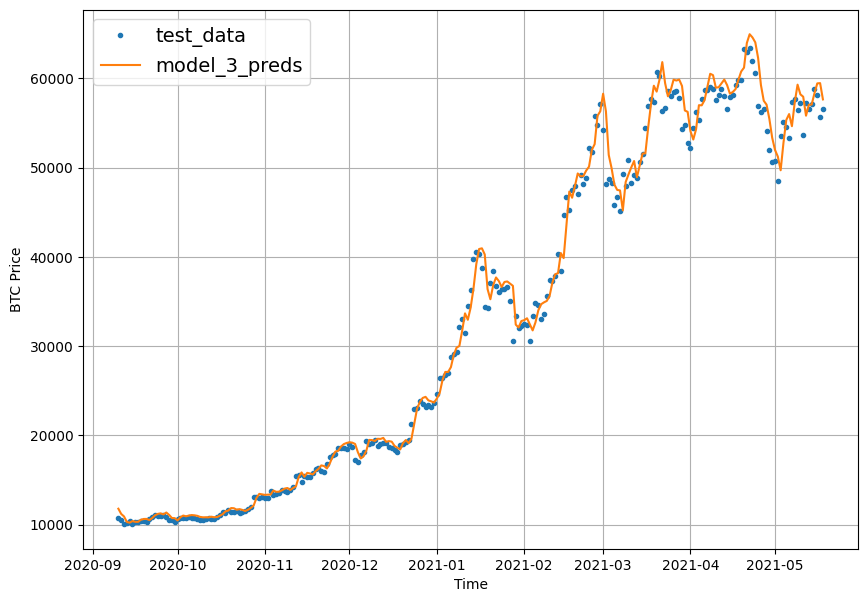

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows_30_7):], test_labels_30_7[:, 0], start=offset, label='test_data')
plot_time_series(X_test[-len(test_windows_30_7):], model_3_preds[:,0], start=offset, format='-', label='model_3_preds')

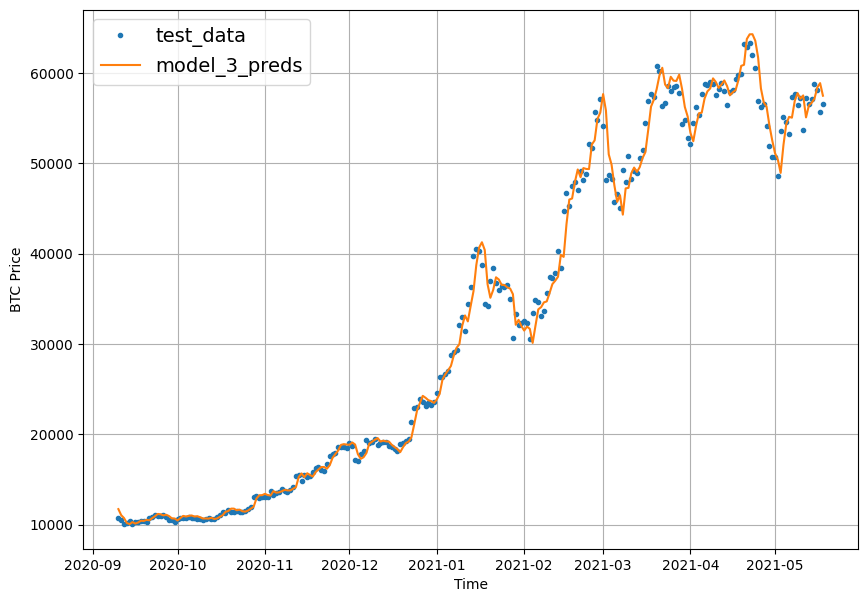

In [ ]:
# or reduce it
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(X_test[-len(test_windows_30_7):], test_labels_30_7[:, 0], start=offset, label='test_data')
plot_time_series(X_test[-len(test_windows_30_7):], tf.reduce_mean(model_3_preds, axis=1), start=offset, format='-', label='model_3_preds')

<Axes: >

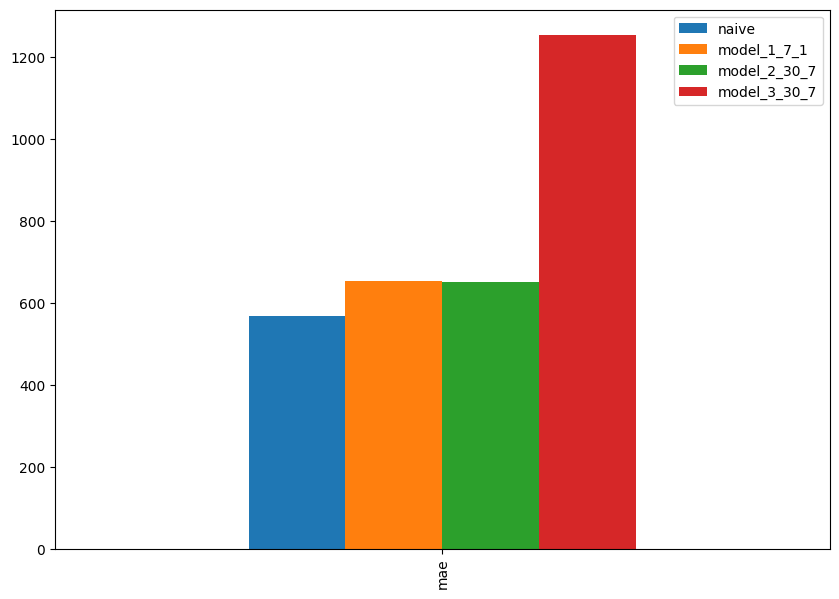

In [ ]:
# Compare dense models
pd.DataFrame({"naive":model_0_results["mae"],
              "model_1_7_1":model_1_results["mae"],
              "model_2_30_7":model_2_results["mae"],
              "model_3_30_7":model_3_results["mae"]}, index=['mae']).plot(figsize=(10, 7), kind='bar')

In [ ]:
# Model 4 : Conv1D - window-7, horizon-1
full_windows_7_1, full_labels_7_1 = make_windows(prices, window_size=7, horizon=1)
train_windows_7_1, test_windows_7_1, train_labels_7_1, test_labels_7_1 = make_train_test_splits(full_windows_7_1,
                                                                                                full_labels_7_1)

# we need input shape of : {batch_size, timesteps, input_dim}
tf.expand_dims(train_windows_7_1[0], axis=1).shape

TensorShape([7, 1])

In [ ]:
# create expand_dims layer
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
expand_dims_layer(train_windows_7_1[0])

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[123.65499],
       [125.455  ],
       [108.58483],
       [118.67466],
       [121.33866],
       [120.65533],
       [121.795  ]], dtype=float32)>

In [ ]:
# conv1d
tf.random.set_seed(42)
model_4 = tf.keras.models.Sequential([
    expand_dims_layer,
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
], name='model_4_conv1d_7_1')
model_4.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae','mse'])
history4 = model_4.fit(train_windows_7_1, train_labels_7_1,
                      epochs=100,
                     batch_size=128,
                     validation_data=(test_windows_7_1, test_labels_7_1),
                      verbose=1)

Epoch 1/100
18/18 [==============================] - 3s 21ms/step - loss: 1905.4204 - mae: 1905.4204 - mse: 10383763.0000 - val_loss: 2685.0593 - val_mae: 2685.0593 - val_mse: 15643556.0000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 309.7208 - mae: 309.7208 - mse: 389260.8438 - val_loss: 1353.5746 - val_mae: 1353.5746 - val_mse: 5083539.5000
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 228.4852 - mae: 228.4852 - mse: 252947.5625 - val_loss: 1127.7290 - val_mae: 1127.7290 - val_mse: 4213248.0000
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 203.5817 - mae: 203.5817 - mse: 213652.1250 - val_loss: 1120.0179 - val_mae: 1120.0179 - val_mse: 4180698.7500
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 199.2753 - mae: 199.2753 - mse: 207385.9219 - val_loss: 1119.2762 - val_mae: 1119.2762 - val_mse: 4055635.2500
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 1

In [ ]:
model_4.evaluate(test_windows_7_1, test_labels_7_1)

18/18 [==============================] - 0s 5ms/step - loss: 636.1047 - mae: 636.1047 - mse: 1306245.7500


[636.104736328125, 636.104736328125, 1306245.75]

In [ ]:
model_4_preds = make_preds(model_4, test_windows_7_1)
model_4_results = evaluate_preds(tf.squeeze(test_labels_7_1), model_4_preds)
model_4_results

18/18 [==============================] - 0s 2ms/step


{'mae': 636.10474,
 'mse': 1306245.8,
 'rmse': 1142.9111,
 'mape': 2.9005103,
 'mase': 1.1174599}

In [ ]:
# Model 5 - LSTM (7_1)
inputs = tf.keras.layers.Input(shape=(7,))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = tf.keras.layers.LSTM(128, activation=tf.keras.activations.relu)(x)
outputs = tf.keras.layers.Dense(1)(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_LSTM_7_1')
model_5.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())
history_5 = model_5.fit(train_windows_7_1, train_labels_7_1,
                        epochs=100,
                        batch_size=128,
                        validation_data=(test_windows_7_1, test_labels_7_1))

Epoch 1/100
18/18 [==============================] - 2s 18ms/step - loss: 2446.6050 - val_loss: 11085.0449
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 1081.4749 - val_loss: 2307.2593
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 277.5391 - val_loss: 1186.7455
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 210.4718 - val_loss: 1106.5076
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 196.0503 - val_loss: 1127.4391
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 193.0516 - val_loss: 1083.6936
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 192.1467 - val_loss: 1096.1925
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 190.3847 - val_loss: 1105.9326
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 188.8000 - val_loss: 1084.7280
Epoch 10/100
18/18 [==============================] - 0s 7ms

In [ ]:
model_5.evaluate(test_windows_7_1, test_labels_7_1)

18/18 [==============================] - 0s 2ms/step - loss: 608.7994


608.7993774414062

In [ ]:
model_5_preds = make_preds(model_5, test_windows_7_1)
model_5_results = evaluate_preds(tf.squeeze(test_labels_7_1), model_5_preds)
model_5_results

18/18 [==============================] - 0s 2ms/step


{'mae': 608.7993,
 'mse': 1312886.9,
 'rmse': 1145.8127,
 'mape': 2.7602582,
 'mase': 1.0694917}

### Multivariate data

In [ ]:
# https://www.cmcmarkets.com/en-nz/learn-cryptocurrencies/bitcoin-halving
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5 # 9th july 2016
block_reward_4 = 6.25 # 18th may 2020

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

block_reward_2_datetime

numpy.datetime64('2012-11-28')

In [ ]:
# create date ranges of where specific block_rewards should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,None
2013-10-02,125.45500,None
2013-10-03,108.58483,None
2013-10-04,118.67466,None
2013-10-05,121.33866,None


In [ ]:
bitcoin_prices_block.iloc[:block_reward_2_days,-1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days : block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days : , -1] = block_reward_4
bitcoin_prices_block.block_reward.value_counts()

block_reward
12.5    1409
25      1012
6.25     366
Name: count, dtype: int64

<Axes: xlabel='Date'>

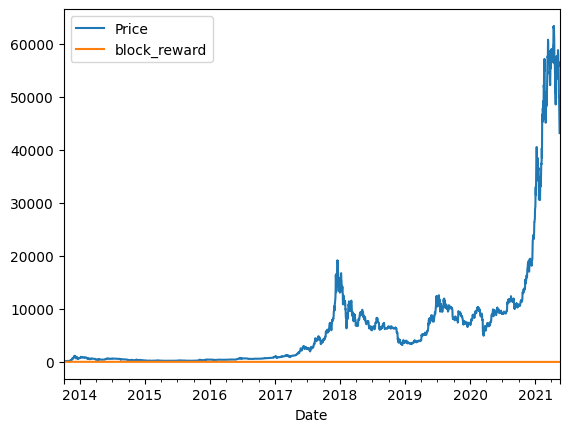

In [ ]:
bitcoin_prices_block.plot()

<Axes: xlabel='Date'>

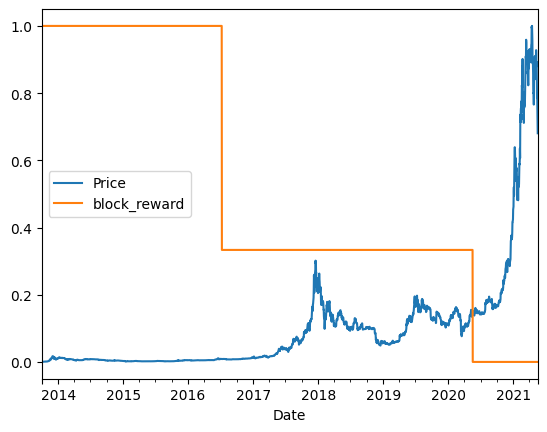

In [ ]:
# normalize the data
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)
scaled_price_block_df.plot()

In [ ]:
## making a windowed dataset for multivariate data
# use pandas dataframe shift
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Create X(windows) and y(horizon) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# split the data
split_size=int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
# Model 6 - Multivariate model(model_1)
tf.random.set_seed(42)
model_6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(HORIZON)
], name='model_6_dense_multivariate_7_1')
model_6.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())
history_6 = model_6.fit(X_train, y_train,
                        epochs=100,
                        batch_size=128,
                        validation_data=(X_test, y_test))

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 1202.9358 - val_loss: 2860.5220
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 273.9187 - val_loss: 973.9928
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 174.5143 - val_loss: 880.9155
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 161.0386 - val_loss: 861.1210
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 154.9351 - val_loss: 848.3035
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 156.7376 - val_loss: 842.5834
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 150.0686 - val_loss: 823.5688
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 147.1654 - val_loss: 815.4520
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 148.2845 - val_loss: 825.5096
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - lo

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 605.3055


605.3054809570312

In [ ]:
model_6_preds = model_6.predict(X_test)
model_6_results = evaluate_preds(y_test, tf.squeeze(model_6_preds))
model_6_results

18/18 [==============================] - 0s 1ms/step


{'mae': 605.3055,
 'mse': 1232008.8,
 'rmse': 1109.9589,
 'mape': 2.746032,
 'mase': 1.0633541}

In [ ]:
model_0_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [ ]:
# Model 7 - NBEATS model - works on univariate time series data only

#create n-beats block input

class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, input_size, theta_size, horizon, n_neurons, n_layers, **kwargs):
        super().__init__(**kwargs)
        self.input_size=input_size
        self.theta_size=theta_size
        self.horizon=horizon
        self.n_neurons=n_neurons
        self.n_layers = n_layers

        #block contains stack of 4 fully connected layers each has relu activation
        self.hidden = [tf.keras.layers.Dense(self.n_neurons, activation=tf.keras.activations.relu) for _ in range(n_layers)]

        #output of block is a theta layer with linear activation
        self.theta_layer = tf.keras.layers.Dense(self.theta_size, activation=tf.keras.activations.linear, name='theta')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # output the backcast and the forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

tf.random.set_seed(42)
# test the n-beats block class
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=512,
                                       n_layers=4)
# create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)

# pass dummy inputs to nbeats block layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# these are the activation outputs of the theta layer (they'll be random due to no training of the model)
tf.squeeze(backcast.numpy()), tf.squeeze(forecast.numpy())

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-0.23261628,  0.03042803, -0.1186793 ,  0.04666237,  0.03057322,
         0.12141654, -0.1927996 ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.236348>)

In [ ]:
# Prepare the data with tf.data
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(i+1)
# bitcoin_prices_nbeats.head()
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size=int(0.8*len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size: ], y[split_size:]

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset)).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
## Setting up hyper parameters for N-BEATS algorithm
N_EPOCHS=5000
BATCH_SIZE=1024
N_NEURONS=512
N_STACKS=30
N_LAYERS=4

INPUT_SIZE= WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
# Residual connections - (subtract and add residuals)
tensor_1 = tf.range(10)+10
tensor_2 = tf.range(10)
tf.keras.layers.subtract([tensor_1, tensor_2]), tf.keras.layers.add([tensor_1, tensor_2])

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32)>)

## Building, compiling and fitting nbeats

In [ ]:
%%time
tf.random.set_seed(42)

# setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                theta_size=THETA_SIZE,
                                horizon=HORIZON,
                                n_neurons = N_NEURONS,
                                n_layers=N_LAYERS,
                                name='InitialBlock')

# Create Input to stack
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name='stack_input')

# create inital backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# use for loop to create stacks of block layer
for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name=f'NBeatsBlock_{i}')(residuals)
    residuals = tf.keras.layers.subtract([residuals, backcast], name=f'subtract_{i}')
    forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')

# put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='model_7_NBEATS_7_1')

model_7.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

#callbacks and fit
history_7 = model_7.fit(train_dataset,
                        epochs=N_EPOCHS,
                        verbose=0,
                        validation_data=test_dataset,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),
                                   tf.keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)])


Epoch 905: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1399: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1499: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 5min 35s, sys: 8.47 s, total: 5min 43s
Wall time: 6min 40s


In [ ]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 20ms/step - loss: 571.7659


571.7659301757812

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

1/1 [==============================] - 1s 1s/step


{'mae': 571.7659,
 'mse': 1164218.5,
 'rmse': 1078.9895,
 'mape': 2.6127539,
 'mase': 1.0044343}

In [ ]:
model_0_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

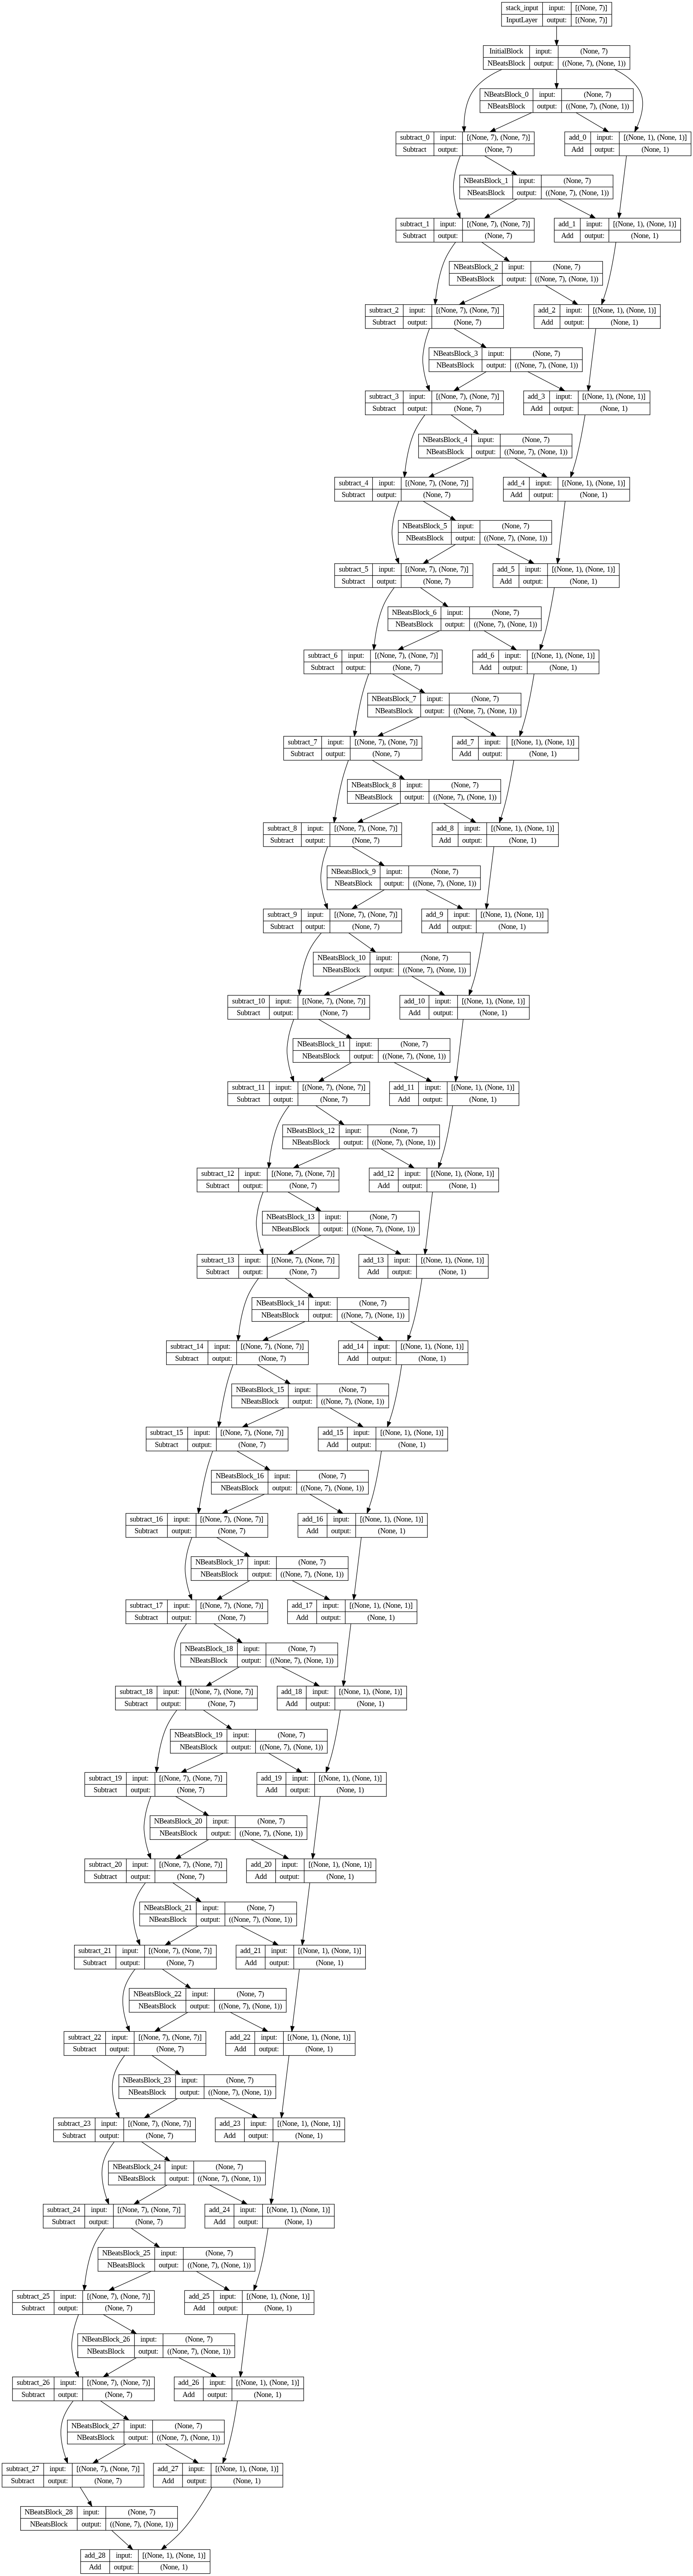

In [ ]:
# plot
from tensorflow.keras.utils import plot_model
plot_model(model_7, show_shapes=True)

### Model 8 - Ensemble

In [ ]:
def get_ensemble_models(horizon=HORIZON, train_data=train_dataset, test_data=test_dataset, num_iter=10,
                        num_epochs=1000, loss_fns=['mae','mse','mape']):
    ensemble_models=[]
    for i in range(num_iter):
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model_number:{i}")
            model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(128, activation=tf.keras.activations.relu, kernel_initializer='he_normal'),
                tf.keras.layers.Dense(128, activation=tf.keras.activations.relu, kernel_initializer='he_normal'),
                tf.keras.layers.Dense(HORIZON, activation=tf.keras.activations.linear)
            ])
            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae','mse'])
            model.fit(train_data,
                      epochs=num_epochs,
                      validation_data=test_data,
                      verbose=0,
                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),
                                 tf.keras.callbacks.ReduceLROnPlateau(patience=100, verbose=1)])
            ensemble_models.append(model)
    return ensemble_models

In [ ]:
%%time
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model_number:0

Epoch 754: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 854: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model_number:0

Epoch 433: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 533: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model_number:0

Epoch 158: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 258: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model_number:1
Optimizing model by reducing: mse for 1000 epochs, model_number:1

Epoch 474: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 574: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing:

In [ ]:
len(ensemble_models), ensemble_models

(15,
  <keras.src.engine.sequential.Sequential at 0x783b12c165f0>])

In [ ]:
# make predictions with ensemble_models
def make_ensemble_preds(emsemble_models, data):
    ensemble_preds=[]
    for model in ensemble_models:
        preds=model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)
ensemble_preds

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 37ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8851.097,  8728.306,  9054.884, ..., 49954.184, 48607.723,
        45525.746],
       [ 8843.222,  8728.646,  9020.199, ..., 49922.348, 47655.695,
        46217.605],
       [ 8795.219,  8738.218,  9071.229, ..., 49753.816, 48413.24 ,
        45503.355],
       ...,
       [ 8799.612,  8763.222,  9044.181, ..., 50028.016, 48395.03 ,
        46856.863],
       [ 8764.865,  8747.425,  9059.44 , ..., 50033.9  , 49863.363,
        47062.99 ],
       [ 8799.513,  8796.707,  9081.633, ..., 50162.152, 48006.38 ,
        45375.11 ]], dtype=float32)>

In [ ]:
model_8_results = evaluate_preds(y_test, ensemble_preds)
model_8_results

{'mae': 578.4028,
 'mse': 1167946.8,
 'rmse': 1080.6415,
 'mape': 2.6281734,
 'mase': 1.0160937}

In [ ]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8798.9795,  8769.237 ,  9063.171 ,  8727.427 ,  8756.293 ,
        8739.043 ,  8641.547 ,  8488.192 ,  8453.723 ,  8513.784 ,
        8207.09  ,  8105.3433,  8059.702 ,  7622.055 ,  7277.87  ,
        7307.27  ,  7074.088 ,  7207.8384,  7136.7407,  7507.1777,
        7402.0684,  7719.564 ,  7576.6787,  7389.9233,  7306.9453,
        7301.9595,  7204.334 ,  7384.9863,  7505.4194,  7535.709 ,
        7545.92  ,  7337.128 ,  7216.098 ,  7178.1953,  7180.319 ,
        7232.6978,  7087.297 ,  7093.961 ,  6880.0464,  6584.5024,
        7393.0146,  7174.838 ,  7135.4395,  7275.7915,  7275.0684,
        7172.675 ,  7217.9766,  7200.662 ,  7165.4175,  7208.0303,
        7297.517 ,  7377.8335,  7244.242 ,  7162.8877,  7153.933 ,
        6948.503 ,  7259.5225,  7339.328 ,  7354.328 ,  7720.7886,
        8089.5044,  8150.907 ,  7860.7017,  8076.0107,  8107.4224,
        8153.779 ,  8105.72  ,  8741.583 ,  8926.609 ,  8767.673 ,
        8927.6

In [ ]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([ 8794.272 ,  8776.49  ,  9062.44  ,  8722.233 ,  8747.114 ,
        8739.561 ,  8641.299 ,  8491.35  ,  8455.083 ,  8520.262 ,
        8199.066 ,  8106.499 ,  8048.9478,  7627.8477,  7281.642 ,
        7315.3926,  7070.8433,  7209.009 ,  7143.883 ,  7506.634 ,
        7409.7944,  7724.3286,  7575.689 ,  7387.534 ,  7312.892 ,
        7302.1665,  7201.488 ,  7387.4253,  7503.203 ,  7535.781 ,
        7549.8896,  7339.841 ,  7221.896 ,  7174.6147,  7183.9644,
        7235.1816,  7086.2456,  7096.833 ,  6876.633 ,  6583.0195,
        7412.13  ,  7180.158 ,  7127.0894,  7283.273 ,  7272.8716,
        7170.2627,  7219.315 ,  7202.758 ,  7163.155 ,  7211.9995,
        7296.121 ,  7380.3276,  7241.2607,  7167.863 ,  7159.4497,
        6946.917 ,  7272.212 ,  7343.03  ,  7349.617 ,  7720.507 ,
        8087.1523,  8156.723 ,  7848.732 ,  8078.6816,  8107.4995,
        8153.344 ,  8111.598 ,  8742.457 ,  8929.09  ,  8755.761 ,
        8931.224 ,  8968.607 ,  8654.476 ,  8629.812 ,  8700.9

In [ ]:
model_8_results_mean = evaluate_preds(y_test, ensemble_mean)
model_8_results_median = evaluate_preds(y_test, ensemble_median)
pd.DataFrame({"model_8_results":model_8_results,
              "model_8_results_mean":model_8_results_mean,
              "model_8_results_median":model_8_results_median}).T

,mae,mse,rmse,mape,mase
model_8_results,578.402771,1167946.75,1080.641479,2.628173,1.016094
model_8_results_mean,566.551514,1135240.25,1065.476562,2.570397,0.995274
model_8_results_median,566.169800,1136901.00,1066.255615,2.561690,0.994604


#### Model 9 - Future prediction model

In [ ]:
X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"], axis=1).to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all)).batch(1024).prefetch(tf.data.AUTOTUNE)

tf.random.set_seed(42)
model_9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
], name='model_9_dense_7_1')

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

history_9 = model_9.fit(dataset_all,
                        epochs=100,
                        verbose=0)

In [ ]:
# make prediction
INTO_FUTURE = 14

def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE):
    future_forecast=[]
    last_window = values[-window_size:]
    for _ in range(into_future):
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on : {last_window} -> Prediciton : {tf.squeeze(future_pred).numpy()}\n")
        future_forecast.append(tf.squeeze(future_pred).numpy())
        last_window = np.append(last_window, future_pred)[-window_size:]
    return future_forecast

future_forecast = make_future_forecasts(y_all, model_9, 14, 7)

1/1 [==============================] - 0s 53ms/step
Predicting on : [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediciton : 55225.59765625

1/1 [==============================] - 0s 20ms/step
Predicting on : [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55225.59765625] -> Prediciton : 52219.44140625

1/1 [==============================] - 0s 18ms/step
Predicting on : [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55225.59765625 52219.44140625] -> Prediciton : 48893.89453125

1/1 [==============================] - 0s 17ms/step
Predicting on : [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55225.59765625 52219.44140625 48893.89453125] -> Prediciton : 48275.13671875

1/1 [==============================] - 0s 17ms/step
Predicting on : [47885.62525472 45604.61575361 43144.47129086 55225.59765625
 52219.44140625 48893.89453125 48275.13

In [ ]:
future_forecast

[55225.598,
 52219.44,
 48893.895,
 48275.137,
 46234.195,
 47858.266,
 48168.31,
 54172.066,
 51121.465,
 47607.184,
 47718.87,
 47322.883,
 50086.473,
 50657.65]

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + np.timedelta64(offset, "D")
    end_date = start_date + np.timedelta64(into_future, "D")
    return np.arange(start_date, end_date, dtype='datetime64[D]')

last_timestep = bitcoin_prices.index[-1]
next_timesteps = get_future_dates(start_date = last_timestep,
                                  into_future=INTO_FUTURE)
next_timesteps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

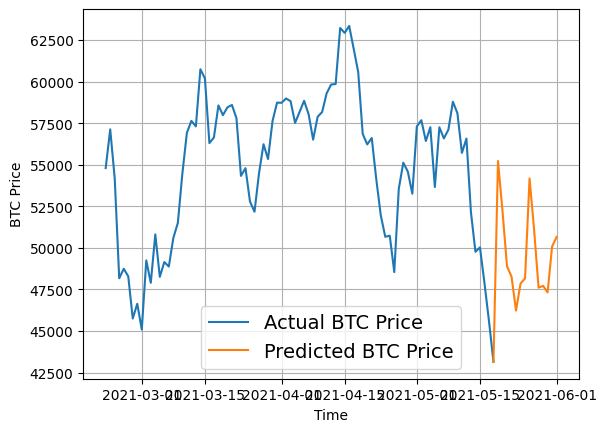

In [ ]:
next_timesteps = np.insert(next_timesteps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, prices[-1])
plt.figure()
plot_time_series(bitcoin_prices.index, prices, start=2700, format='-', label='Actual BTC Price')
plot_time_series(next_timesteps, future_forecast, format='-', label='Predicted BTC Price')

### Turkey model

In [ ]:
# let us introduce turkey problem into our data
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1]/100
btc_price_turkey[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361,   431.44471291])

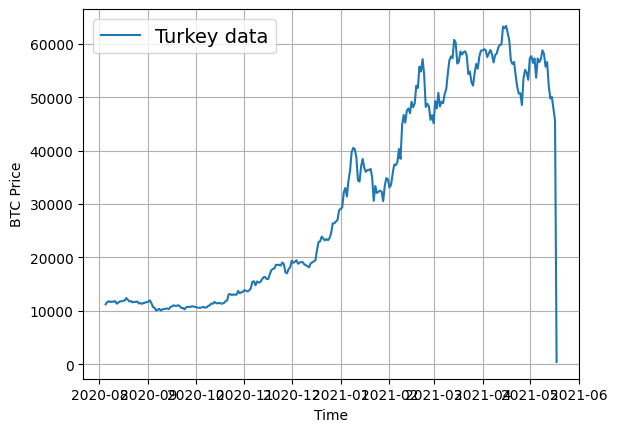

In [ ]:
btc_timesteps_turkey = np.array(bitcoin_prices.index)
plot_time_series(btc_timesteps_turkey, btc_price_turkey, format='-', label='Turkey data', start=2500)

In [ ]:
# create train_test sets
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=7, horizon=1)
X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
model_10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)
], name='model_10_7_1')
model_10.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam())
history_10 = model_10.fit(X_train, y_train,
                          epochs=100,
                         verbose=0,
                         batch_size=128,
                         validation_data=(X_test, y_test))

In [ ]:
model_10.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 736.9869


736.9868774414062

In [ ]:
model_10_preds = make_preds(model_10, X_test)
model_10_results = evaluate_preds(y_test, model_10_preds)
model_10_results

18/18 [==============================] - 0s 1ms/step


{'mae': 16984.504,
 'mse': 603909800.0,
 'rmse': 23425.668,
 'mape': 119.2809,
 'mase': 26.283577}

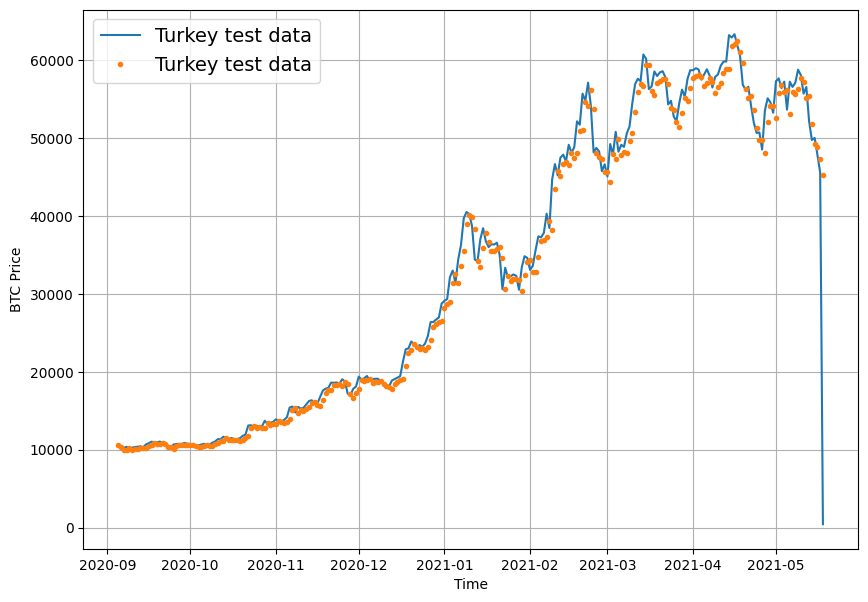

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(btc_timesteps_turkey[-len(X_test):], btc_price_turkey[-len(y_test):], format='-', label='Turkey test data', start=300)
plot_time_series(btc_timesteps_turkey[-len(X_test):], model_10_preds, label='Turkey test data', start=300)

## Compare all models

In [ ]:
model_results = pd.DataFrame({"naive":model_0_results,
              "model_1_7_1":model_1_results,
              "model_2_30_1":model_2_results,
              "model_3_30_7":model_3_results,
              "model_4_COnv1d":model_4_results,
              "model_5_LSTM":model_5_results,
              "model_6_multivariate":model_6_results,
              "model_7_NBEATS":model_7_results,
              "model_8_ensemble":model_8_results,
              "model_10_turkey":model_10_results}).T
model_results

,mae,mse,rmse,mape,mase
naive,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_7_1,653.530396,1.348882e+06,1161.413574,2.974331,1.148072
model_2_30_1,651.806396,1.417453e+06,1190.568481,3.034032,1.139364
model_3_30_7,1253.558472,5.350294e+06,1444.888184,5.621202,2.230637
model_4_COnv1d,636.104736,1.306246e+06,1142.911133,2.900510,1.117460
model_5_LSTM,608.799316,1.312887e+06,1145.812744,2.760258,1.069492
model_6_multivariate,605.305481,1.232009e+06,1109.958862,2.746032,1.063354
model_7_NBEATS,571.765930,1.164218e+06,1078.989502,2.612754,1.004434
model_8_ensemble,578.402771,1.167947e+06,1080.641479,2.628173,1.016094
model_10_turkey,16984.503906,6.039098e+08,23425.667969,119.280899,26.283577


<Axes: >

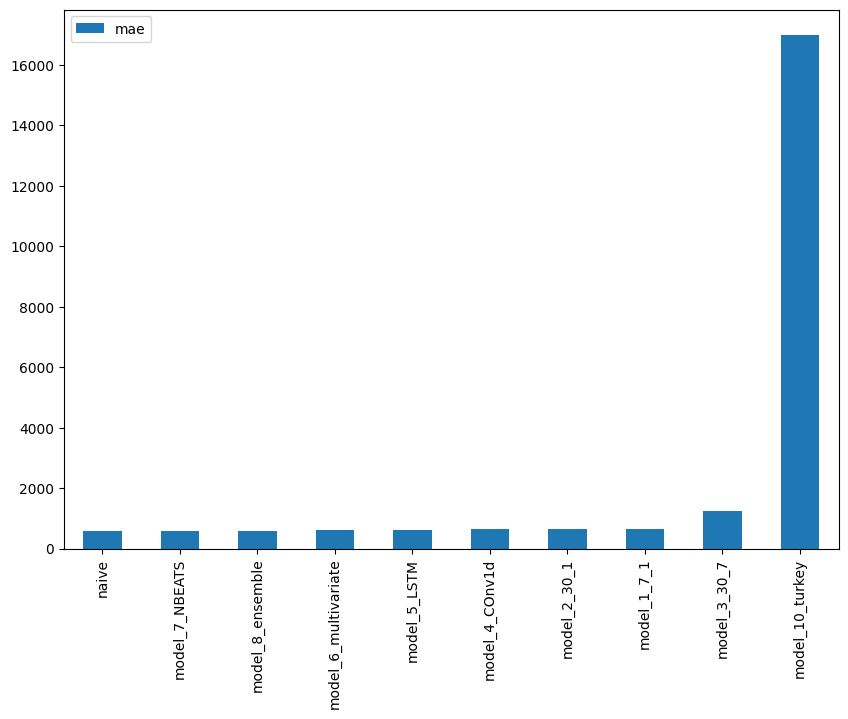

In [ ]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10,7), kind='bar')